In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Adjust the path for c2qa and bosonic-qiskit modules
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)

# Add the `playground` directory to the Python path
playground_path = Path.cwd().parent.parent  # Move two levels up to `playground`
if str(playground_path) not in sys.path:
    sys.path.append(str(playground_path))


# Qiskit and related imports
# Qiskit and related imports
import qiskit
from qiskit.quantum_info import state_fidelity, Statevector, SparsePauliOp, Operator
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter

# Project-specific imports
import c2qa
import c2qa.util as util
from bosonic_operator_costs.all_qubit_utils import (
    create_annihilation_operator,
    create_creation_operator
)



### Pure trotterization method
This notebook performs a resource estimation for the Trotterization of a displacement Hamiltonian on an all-qubit quantum computer. The displacement Hamiltonian is given by:

$$
H = i\left( \alpha a^\dagger - \alpha^* a \right)
$$

which generates the displacement operator:

$$
e^{-iHt} = e^{\alpha a^\dagger - \alpha^* a}
$$

We analyze different orders of Trotterization and the associated logical gate counts required.

Below, we define the displacement Hamiltonian and the initial state, which consists of all qubits initialized in $ |0\rangle $.

In [2]:
def displacement_hamiltonian(n_max, alpha=1):
    """
    Creates the matrix representation of the operator i*alpha(b^dagger - b).

    Parameters:
        n_max (int): The Fock cutoff.
        alpha (complex, optional): The amount of displacement. Defaults to 1.

    Returns:
        np.ndarray: The matrix representation of i*alpha(b^dagger - b).
    """
    b = create_annihilation_operator(n_max)
    b_dag = create_creation_operator(n_max)

    hamiltonian = 1j* (alpha * b_dag - alpha.conjugate() * b)
    return hamiltonian


def define_initial_state(num_modes, n_max):
    """
    Define the initial state vector for the system.

    Parameters:
        n_qubits (int): The number of qubits in the system.

    Returns:
        Statevector: The initial quantum state.
    """
    n_qubits = num_modes * int(np.ceil(np.log2(n_max + 1)))
    initial_state_vector = np.zeros(2**n_qubits, dtype=complex)
    initial_state_vector[0] = 1.0

    return Statevector(initial_state_vector)

Trotterization is a method for approximating the time evolution operator \( e^{-iHt} \) by decomposing the Hamiltonian into a product of exponentiated terms. The first-order Trotter expansion is given by:

$$
e^{-iHt} = e^{-i\sum_{i=1}^{j} H_i t} \approx e^{-iH_1 t} e^{-iH_2 t} \dots e^{-iH_j t} + O(t^2)
$$

where the total evolution time is $ t = n \cdot dt $, with $ n $ as the number of Trotter steps and $ dt $ as the time per step. As $ n \to \infty $ or $ dt \to 0 $, this approximation becomes exact.

Below, we perform a sanity check by comparing the fidelity between the exact displacement evolution (using bosonic qiskit) and its Trotterized implementation on an all-qubit system. We use different Trotter orders for a range of real displacement parameters $ \alpha $ with fixed evolution time $ t = 1 $, a fixed bosonic cutoff, and varying numbers of Trotter steps. The Hamiltonian is expressed as a sum of Pauli strings using Qiskit's `SparsePauliOp`, and then Trottization is done using `PauliEvolutionGate`.


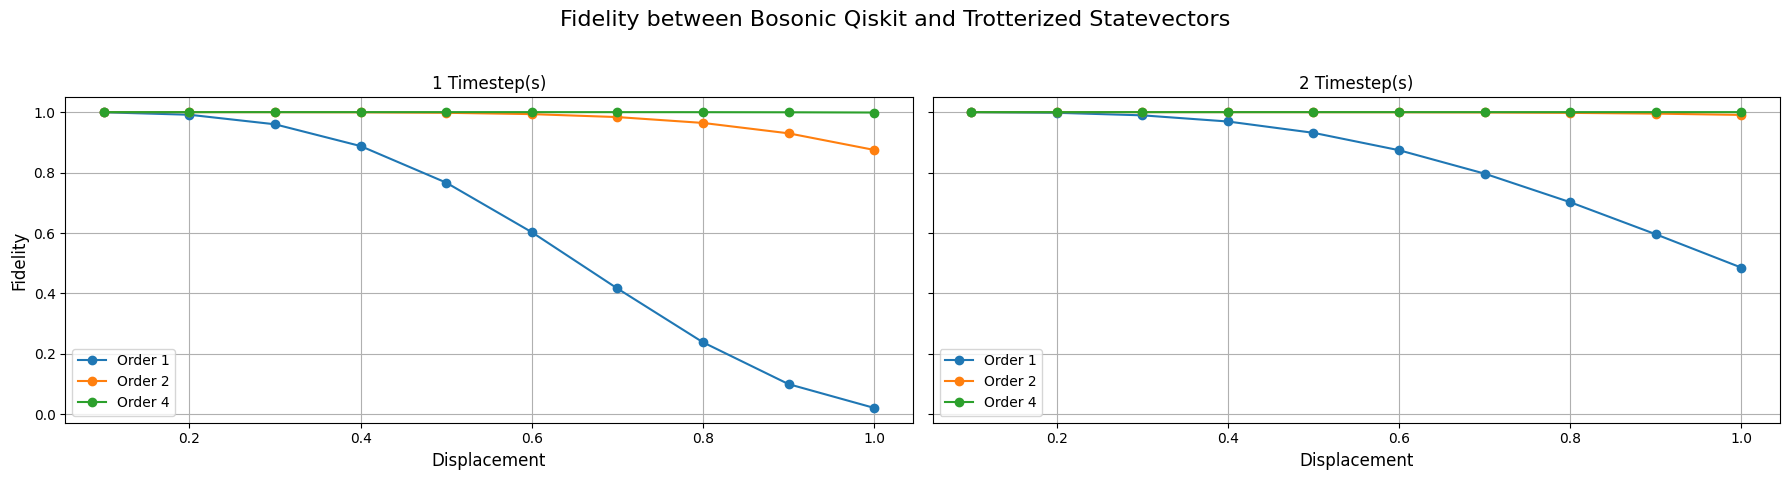

In [3]:
# =============================================================================
# Parameters and Hamiltonian Setup
# =============================================================================
num_qubits_per_mode = 3
n_max = 2**num_qubits_per_mode - 1
num_modes = 1

# Total evolution time remains fixed
evolution_time = 1.0       

# Range of alpha values for displacement
alpha_values = np.linspace(0.1, 1.0, 10)  

# Trotter orders to evaluate
trotter_orders = [1, 2, 4]

# Define different numbers of timesteps to evaluate
timestep_list = [1, 2]

# =============================================================================
# Function for Trotter Evolution with Variable Order and Timesteps
# =============================================================================
def get_trotter_circuit(H, dt, num_timesteps, initial_state, order=1):
    """
    Applies Trotter evolution to the initial_state using the specified order
    and number of timesteps, and returns the resulting circuit.
    """
    # Select synthesis method based on desired order
    if order == 1:
        synthesis_method = LieTrotter()
    elif order == 2:
        synthesis_method = SuzukiTrotter()  # Defaults to second order
    elif order == 4:
        synthesis_method = SuzukiTrotter(order=4)
    elif order == 6:
        synthesis_method = SuzukiTrotter(order=6)
    else:
        raise ValueError(f"Unsupported Trotter order: {order}. Supported orders: 1, 2, 4, 6.")
    
    trotter_gate = PauliEvolutionGate(H, dt, synthesis=synthesis_method)
    circuit = QuantumCircuit(H.num_qubits)
    
    # Initialize the circuit with the initial_state
    circuit.initialize(initial_state.data, range(H.num_qubits))
    
    # Append the Trotter evolution gate repeatedly for the number of timesteps
    for _ in range(num_timesteps):
        circuit.append(trotter_gate, range(H.num_qubits))
    
    return circuit

# =============================================================================
# Loop Over Timesteps and Alpha Values to Compute and Plot Fidelities
# =============================================================================
fig, axes = plt.subplots(1, len(timestep_list), figsize=(18, 5), sharey=True)

for idx, num_timesteps in enumerate(timestep_list):
    dt = evolution_time / num_timesteps  # Update dt for current number of timesteps
    fidelity_results = {order: [] for order in trotter_orders}

    for alpha in alpha_values:
        # Create initial state and displacement Hamiltonian
        initial_state = define_initial_state(num_modes, n_max)
        hamiltonian_matrix = displacement_hamiltonian(n_max, alpha)
        H = SparsePauliOp.from_operator(Operator(hamiltonian_matrix))

        # =============================================================================
        # Bosonic Qiskit Displacement Simulation
        # =============================================================================
        # Setup qumode registers for Bosonic Qiskit
        qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode=num_qubits_per_mode)
        qumode = qmr[0]  # Convenient labeling

        # Initialize circuit (starts in |0⟩ by default)
        bosonic_circuit = c2qa.CVCircuit(qmr)

        # Apply displacement operation
        bosonic_circuit.cv_d(alpha, qumode)

        # Simulate bosonic circuit and obtain statevector
        bosonic_statevector, _, _ = c2qa.util.simulate(bosonic_circuit)

        # =============================================================================
        # Trotter Evolution and Fidelity Calculation for Each Order
        # =============================================================================
        for order in trotter_orders:
            # Compute Trotter circuit with the specified number of timesteps
            circuit = get_trotter_circuit(H, dt, num_timesteps, initial_state, order=order)

            # Compute Trotterized statevector using the selected order
            trotter_statevector = Statevector.from_instruction(circuit)

            # Compute fidelity between bosonic and Trotterized statevectors
            fidelity = state_fidelity(bosonic_statevector, trotter_statevector)

            # Store fidelity
            fidelity_results[order].append(fidelity)

    # Plot fidelity vs alpha for each Trotter order on the current subplot
    ax = axes[idx]
    for order in trotter_orders:
        ax.plot(alpha_values, fidelity_results[order], 
                marker='o', linestyle='-', label=f'Order {order}')
    ax.set_title(f'{num_timesteps} Timestep(s)')
    ax.set_xlabel('Displacement', fontsize=12)
    if idx == 0:
        ax.set_ylabel('Fidelity', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True)

plt.suptitle('Fidelity between Bosonic Qiskit and Trotterized Statevectors', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


As expected, increasing the number of Trotter steps improves the fidelity of the evolution, and higher-order Trotterization, which reduces error, further enhances the accuracy.

Below, for each Trotter order, we calculate the number of entangling and rotation gates required as a function of the bosonic cutoff. This count is for a single Trotter step.

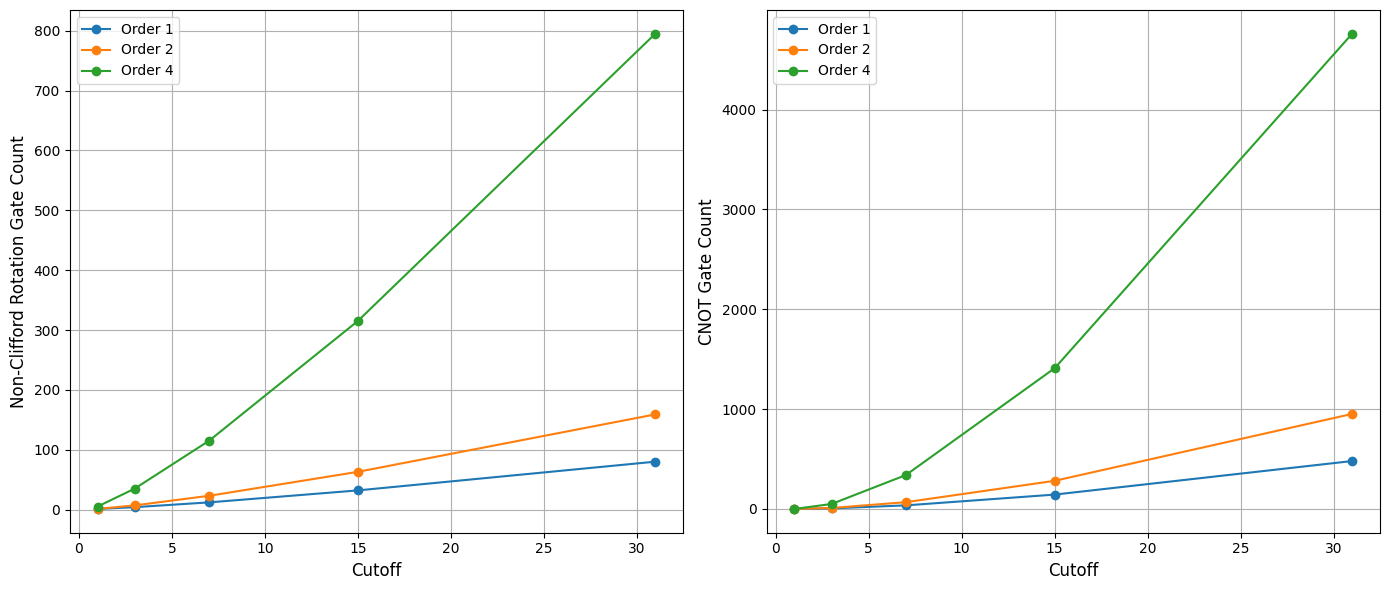

In [4]:
# =============================================================================
# Parameters for Gate Count Analysis
# =============================================================================
alpha_fixed = 0.5
evolution_time = 1
num_timesteps = 1
dt = evolution_time / num_timesteps #just a single trotter step

# Trotter orders to consider
trotter_orders = [1, 2, 4]

# Range of num_qubits_per_mode values to simulate different cutoffs
qubit_counts = range(1, 6)  
cutoff_values = [2**q - 1 for q in qubit_counts]  # Corresponding cutoffs
num_modes = 1

# Dictionaries to store results: structure {order: [values for each cutoff]}
rotation_gate_counts = {order: [] for order in trotter_orders}
cnot_gate_counts = {order: [] for order in trotter_orders}


# =============================================================================
# Loop Over Cutoff Values and Compute Gate Counts for Each Order
# =============================================================================
for cutoff in cutoff_values:
    # Create initial state and Hamiltonian for current cutoff
    initial_state = define_initial_state(num_modes, cutoff)
    hamiltonian_matrix = displacement_hamiltonian(cutoff, alpha_fixed)
    H = SparsePauliOp.from_operator(Operator(hamiltonian_matrix))

    # Loop over each Trotter order
    for order in trotter_orders:
        # Get the decomposed Trotter circuit for the given order
        circuit = get_trotter_circuit(H, dt, num_timesteps, initial_state, order=order).decompose(reps=1)

        # Count gates
        gate_counts = circuit.count_ops()
        r_gate_count = gate_counts.get('rz', 0)  
        r_gate_count += gate_counts.get('ry', 0)
        cnot_gate_count = gate_counts.get('cx', 0)  # CNOT gate count

        # Store the counts 
        rotation_gate_counts[order].append(r_gate_count)
        cnot_gate_counts[order].append(cnot_gate_count)


# =============================================================================
# Plotting in a 1x2 grid
# =============================================================================

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Rotation Gate Count vs Cutoff
for order in trotter_orders:
    axs[0].plot(cutoff_values, rotation_gate_counts[order], marker='o', label=f'Order {order}')
axs[0].set_xlabel('Cutoff', fontsize=12)
axs[0].set_ylabel('Non-Clifford Rotation Gate Count', fontsize=12)
# axs[0].set_yscale("log")  
axs[0].legend()
axs[0].grid(True)

# CNOT Gate Count vs Cutoff
for order in trotter_orders:
    axs[1].plot(cutoff_values, cnot_gate_counts[order], marker='o', label=f'Order {order}')
axs[1].set_xlabel('Cutoff', fontsize=12)
axs[1].set_ylabel('CNOT Gate Count', fontsize=12)
# axs[1].set_yscale("log")  
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()


### CNOT staircase count
Using a first-order Trotterization, we calculate the resources for a single Trotter step. Exponentiating a Pauli string of weight $p$ requires $2(p - 1)$ CNOT gates and one non-Clifford rotation. Therefore, for a Hamiltonian 
$ H = \sum_{j=1}^P p_j, $
where each Pauli string $p_j$ has weight $r_j$ (ignoring identity operators), the total CNOT count is 
$ \sum_{j=1}^P 2(r_j - 1), $
and the number of non-Clifford rotations is $P$.

We also know for second order it's 
$ \sum_{j=1}^P 4(r_j - 1) $ CNOTs and $ 2P $ non-Clifford rotations, because the second-order scheme requires applying each exponential twice in a time-symmetric fashion.


As a check, we'll plot these counts alongside our actual Trotterized qiskit circuit.

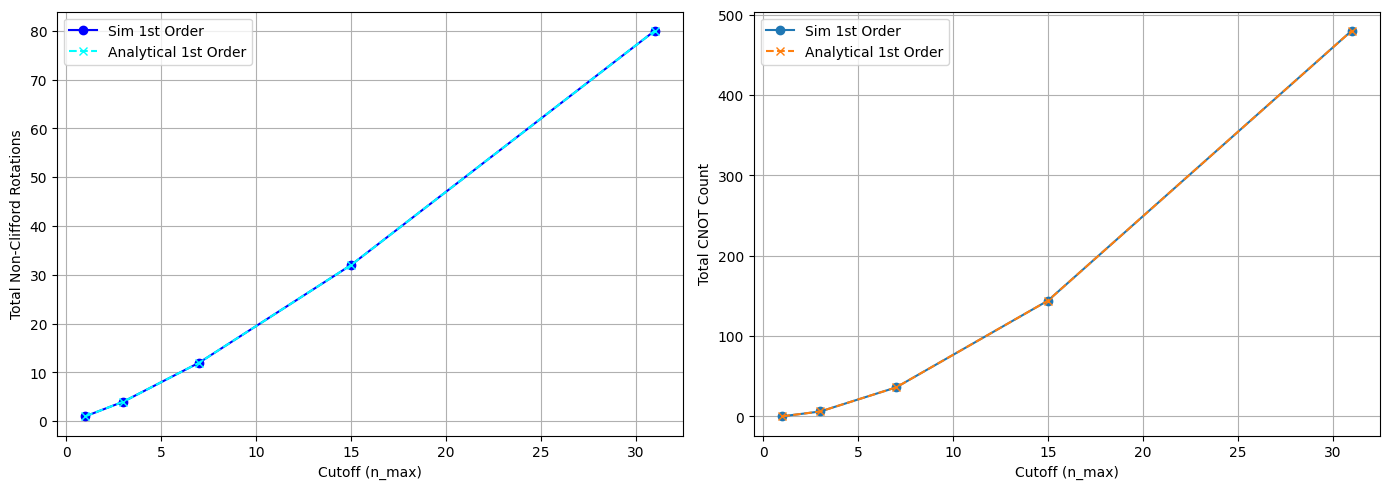

In [5]:
# =============================================================================
# Analytical Calculation for First and Second Order
# =============================================================================
analytical_cnot_counts_1 = []

analytical_nonclifford_counts_1 = []

# Range of num_qubits_per_mode values to simulate different cutoffs
for cutoff in cutoff_values:
    # Generate the Hamiltonian matrix for the current cutoff
    hamiltonian_matrix = displacement_hamiltonian(cutoff, alpha_fixed)
    
    # Convert matrix to a SparsePauliOp
    H = SparsePauliOp.from_operator(Operator(hamiltonian_matrix))
    
    # Extract terms as a list of tuples: (pauli_string, coefficient)
    terms = H.to_list()
    
    total_cnot_count_1 = 0
    
    for p_str, coeff in terms:
        # Calculate effective length ignoring 'I'
        effective_length = len(p_str.replace('I', ''))
        
        # First-order CNOT count for the current term
        total_cnot_count_1 += 2 * max(effective_length - 1, 0)
        
    
    analytical_cnot_counts_1.append(total_cnot_count_1)
    
    # Non-Clifford counts for each order
    nonclifford_count_1 = len(terms)           # first-order
    
    analytical_nonclifford_counts_1.append(nonclifford_count_1)

# =============================================================================
# Compare Simulation and Analytical Results on Combined Graphs
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Non-Clifford Rotations Comparison 
axes[0].plot(cutoff_values, rotation_gate_counts[1], marker='o', linestyle='-', 
             label='Sim 1st Order', color='blue')
axes[0].plot(cutoff_values, analytical_nonclifford_counts_1, marker='x', linestyle='--', 
             label='Analytical 1st Order', color='cyan')

axes[0].set_xlabel('Cutoff (n_max)')
axes[0].set_ylabel('Total Non-Clifford Rotations')
axes[0].legend()
axes[0].grid(True)

# CNOT Counts Comparison 
axes[1].plot(cutoff_values, cnot_gate_counts[1], marker='o', linestyle='-', 
             label='Sim 1st Order')
axes[1].plot(cutoff_values, analytical_cnot_counts_1, marker='x', linestyle='--', 
             label='Analytical 1st Order')
axes[1].set_xlabel('Cutoff (n_max)')
axes[1].set_ylabel('Total CNOT Count')
axes[1].legend()
axes[1].grid(True)


plt.tight_layout()
plt.show()